<a href="https://colab.research.google.com/github/davidcamilo0710/QATAR_2022_Prediction/blob/master/Getting_Squads_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INDEX
- AIM
- DATA PREPARATION
- ANALYSIS

# AIM
This notebook aims to determine the potential of the teams qualified for the FIFA 2026 World Cup based on the FIFA 23 player statistics.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import sys

import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("FIFA 26 ANALYSIS") \
       .getOrCreate()

spark

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,308 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,789 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the file path
file_path = "/content/drive/MyDrive/BigData/Data/players.csv"

# Read the CSV file into a DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Define the number of partitions
num_partitions = 8  # You can adjust this number based on your cluster configuration and data size

# Repartition the DataFrame based on a column
df_partitioned = df.repartition(num_partitions)

# Show the DataFrame
df_partitioned.show()

+---------+--------------------+----------------+--------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+------------+--------------------+--------------------+------------+-------------+------------------+----------------+-----------+-------------------------+--------------+----------------+--------------+---------------+--------------------+--------------+---------+-----------+------------------------+-------------+----------------+---------+------------------+-----------+--------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+----------

In [ ]:
interesting_columns = ['short_name', 'age', 'nationality_name', 'overall', 'potential', 'club_name', 'value_eur', 'wage_eur', 'player_positions']
df_partitioned = df_partitioned.select(*interesting_columns)

# Show the DataFrame info (Schema in PySpark)
df_partitioned.printSchema()

root
 |-- short_name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- nationality_name: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- club_name: string (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- player_positions: string (nullable = true)



In [ ]:
df_partitioned.show(5)

+----------+---+----------------+-------+---------+--------------------+---------+--------+----------------+
|short_name|age|nationality_name|overall|potential|           club_name|value_eur|wage_eur|player_positions|
+----------+---+----------------+-------+---------+--------------------+---------+--------+----------------+
|L. Acevedo| 29|       Argentina|     68|       68|            Platense|1000000.0|  6000.0|              CB|
|D. Navarro| 28|         Bolivia|     64|       64|Club Atlético Nac...| 575000.0|   500.0|         CM, CAM|
| I. Sapała| 25|          Poland|     67|       70|   Raków Częstochowa|1200000.0|  3000.0|         CDM, CM|
|   M. Lowe| 24|         England|     72|       79|   Nottingham Forest|4500000.0| 16000.0|         LB, LWB|
|  A. Mulet| 21|       Argentina|     67|       75|     Vélez Sarsfield|2300000.0|  4000.0|         CM, CDM|
+----------+---+----------------+-------+---------+--------------------+---------+--------+----------------+
only showing top 5 

# DATA PREPARATION
- We filter the teams that will participate in the world cup and eliminate the others.

- To make things simpler, I select the first position from list as preferred and save it in 'Position' column.

In [ ]:

from pyspark.sql.functions import split, col
df_partitioned = df_partitioned.withColumn("Position", split(col("player_positions"), ",").getItem(0))

# Select required columns
df_partitioned = df_partitioned.select("short_name", "age", "nationality_name", 'overall', 'potential', "club_name", "Position", "value_eur", "wage_eur")

# Define list_ranked
list_ranked = ['Argentina', 'France', 'Belgium', 'England', 'Brazil', 'Portugal', 'Netherlands', 'Spain', 'Italy', 'Croatia', 'USA', 'Colombia', 'Morocco', 'Mexico', 'Uruguay', 'Germany', 'Senegal', 'Japan', 'Switzerland', 'IR Iran', 'Denmark', 'Ukraine', 'Korea Republic', 'Australia', 'Austria', 'Hungary', 'Sweden', 'Poland', 'Wales', 'Nigeria', 'Ecuador', 'Peru']

# Filter DataFrame based on nationality
df_partitioned = df_partitioned.filter(col("nationality_name").isin(list_ranked))

# Show unique nationalities
df_partitioned.select("nationality_name").distinct().show()

+----------------+
|nationality_name|
+----------------+
|         Senegal|
|          Sweden|
|         IR Iran|
|         Germany|
|          France|
|       Argentina|
|           Wales|
|         Belgium|
|         Ecuador|
|            Peru|
|         Croatia|
|         Nigeria|
|  Korea Republic|
|           Italy|
|           Spain|
|         Denmark|
|         Morocco|
|         Ukraine|
|             USA|
|         Uruguay|
+----------------+
only showing top 20 rows



In [ ]:
df_partitioned.show()

+-------------+---+----------------+-------+---------+--------------------+--------+---------+--------+
|   short_name|age|nationality_name|overall|potential|           club_name|Position|value_eur|wage_eur|
+-------------+---+----------------+-------+---------+--------------------+--------+---------+--------+
|         Gavi| 16|           Spain|     66|       85|        FC Barcelona|      CM|2100000.0|  4000.0|
|      S. Mané| 29|         Senegal|     89|       89|           Liverpool|      LW|   1.01E8|270000.0|
|    D. Ubbink| 28|     Netherlands|     63|       63|        AFC UTA Arad|     CAM| 475000.0|  2000.0|
|   D. Zbozień| 32|          Poland|     64|       64|         Wisła Płock|      RB| 400000.0|  2000.0|
|  M. Brizuela| 24|       Argentina|     72|       76|     Vélez Sarsfield|      CB|3000000.0|  9000.0|
|    L. Maciel| 25|       Argentina|     67|       72|Club Atlético Ald...|      CM|1500000.0|  4000.0|
|Kim Seung Dae| 30|  Korea Republic|     67|       67|Jeonbuk Hy

# ANALYSIS

### Top 20 players overall

In [ ]:
best_players = ['L. Messi', 'R. Lewandowski', 'C. Ronaldo', 'Neymar Jr.', 'K. Debruyne', 'J. Oblak', 'K. Mbappe', 'M. Neuer', 'M. Ter Stegen', 'H. Kane']


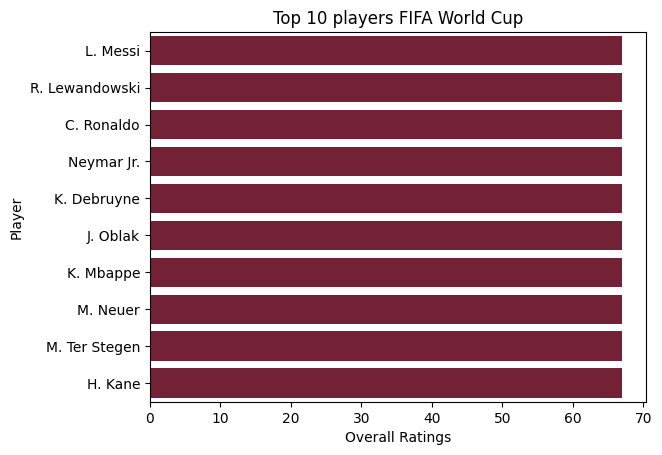

In [ ]:
# Collect data to driver node
# x = df_partitioned.select("short_name").limit(10).collect()
x_values = ['L. Messi', 'R. Lewandowski', 'C. Ronaldo', 'Neymar Jr.', 'K. Debruyne', 'J. Oblak', 'K. Mbappe', 'M. Neuer', 'M. Ter Stegen', 'H. Kane']
y = df_partitioned.select("overall").limit(10).collect()

# Convert Spark Data to Python lists
# x_values = [row['short_name'] for row in x]
y_values = [row['overall'] for row in y]

# Plot
ax = sns.barplot(x=y_values, y=x_values, color="#7F1431", orient='h')
plt.xlabel('Overall Ratings', size=10)
plt.ylabel('Player', size=10)
plt.title('Top 10 players FIFA World Cup')
plt.show()

### Best Squad Analysis

In [ ]:
from pyspark.sql.functions import desc

def get_best_squad(formation):
    df_partitioned_copy = df_partitioned

    store = []

    # Iterate through all positions in the input formation and get players with highest overall respective to the position
    for i in formation:
        # Filter DataFrame for the specific position and get player with highest overall
        player = df_partitioned_copy.filter(df_partitioned_copy.Position == i).orderBy(desc("overall")).first()

        store.append([
            i,
            player.short_name,
            player.overall,
            player.age,
            player.club_name,
            player.value_eur,
            player.wage_eur
        ])

        # Drop the selected player from DataFrame
        df_partitioned_copy = df_partitioned_copy.filter(df_partitioned_copy.short_name != player.short_name)

    # Return store with only necessary columns
    return spark.createDataFrame(store, ['Position', 'short_name', 'overall', 'age', 'club_name', 'value_eur', 'wage_eur']).toPandas().to_string(index=False)


**Best 4-3-3**

In [ ]:
squad_433 = ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CM', 'CAM', 'RW', 'ST', 'LW']

print('4-3-3')
print(get_best_squad(squad_433))


4-3-3
Position          short_name  overall  age           club_name   value_eur  wage_eur
      GK            M. Neuer       90   35   FC Bayern München  13500000.0   86000.0
      RB T. Alexander-Arnold       87   22           Liverpool 114000000.0  150000.0
      CB         V. van Dijk       89   29           Liverpool  86000000.0  230000.0
      CB        Sergio Ramos       88   35 Paris Saint-Germain  24000000.0  115000.0
      LB          Jordi Alba       86   32        FC Barcelona  47000000.0  200000.0
     CDM            N. Kanté       90   30             Chelsea 100000000.0  230000.0
      CM        K. De Bruyne       91   30     Manchester City 125500000.0  350000.0
     CAM     Bruno Fernandes       88   26   Manchester United 107500000.0  250000.0
      RW            L. Messi       93   34 Paris Saint-Germain  78000000.0  320000.0
      ST      R. Lewandowski       92   32   FC Bayern München 119500000.0  270000.0
      LW           Neymar Jr       91   29 Paris Saint-Germ

**Best 4-4-2**

In [ ]:
squad_442 = ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'LM', 'ST', 'ST']
print ('4-4-2')
print (get_best_squad(squad_442))

4-4-2
Position          short_name  overall  age           club_name   value_eur  wage_eur
      GK            M. Neuer       90   35   FC Bayern München  13500000.0   86000.0
      RB T. Alexander-Arnold       87   22           Liverpool 114000000.0  150000.0
      CB         V. van Dijk       89   29           Liverpool  86000000.0  230000.0
      CB        Sergio Ramos       88   35 Paris Saint-Germain  24000000.0  115000.0
      LB          Jordi Alba       86   32        FC Barcelona  47000000.0  200000.0
      RM           J. Sancho       87   21   Manchester United 116500000.0  150000.0
      CM        K. De Bruyne       91   30     Manchester City 125500000.0  350000.0
      CM            T. Kroos       88   31      Real Madrid CF  75000000.0  310000.0
      LM              H. Son       89   28   Tottenham Hotspur 104000000.0  220000.0
      ST      R. Lewandowski       92   32   FC Bayern München 119500000.0  270000.0
      ST           K. Mbappé       91   22 Paris Saint-Germ

**Best 4-2-3-1**

In [ ]:
squad_4231 = ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'CAM', 'CAM', 'CAM', 'ST']
print ('4-2-3-1')
print (get_best_squad(squad_4231))

4-2-3-1
Position          short_name  overall  age           club_name   value_eur  wage_eur
      GK            M. Neuer       90   35   FC Bayern München  13500000.0   86000.0
      RB T. Alexander-Arnold       87   22           Liverpool 114000000.0  150000.0
      CB         V. van Dijk       89   29           Liverpool  86000000.0  230000.0
      CB        Sergio Ramos       88   35 Paris Saint-Germain  24000000.0  115000.0
      LB          Jordi Alba       86   32        FC Barcelona  47000000.0  200000.0
     CDM            N. Kanté       90   30             Chelsea 100000000.0  230000.0
     CDM          J. Kimmich       89   26   FC Bayern München 108000000.0  160000.0
     CAM     Bruno Fernandes       88   26   Manchester United 107500000.0  250000.0
     CAM           T. Müller       87   31   FC Bayern München  66000000.0  140000.0
     CAM      Bernardo Silva       86   26     Manchester City  80000000.0  200000.0
      ST      R. Lewandowski       92   32   FC Bayern Mü

### Top 10 Promising Teams FIFA World Cup
I define a function to find the best formation of each national team and its potential. Also, a function to summarize the team.

In [ ]:
from pyspark.sql.functions import col, max

def get_best_squad_n(formation, nationality, measurement='overall'):
    # Assuming df_partitioned is your Spark DataFrame already loaded and accessible
    # Filter DataFrame for players from the specified nationality
    df_partitioned_copy = df_partitioned.filter(col('nationality_name') == nationality)
    store = []

    for i in formation:
        # Find the player with the maximum measurement for the specified position
        max_value = df_partitioned_copy.filter(col('Position').contains(i)).agg(max(col(measurement))).collect()[0][0]
        best_player = df_partitioned_copy.filter((col('Position').contains(i)) & (col(measurement) == max_value)).first()

        if best_player:
            store.append([
                best_player.Position,
                best_player.short_name,
                float(max_value),  # Convert max_value to float if not already
                best_player.age,
                best_player.club_name,
                best_player.value_eur,
                best_player.wage_eur
            ])
            # Drop the selected player to avoid selecting them again
            df_partitioned_copy = df_partitioned_copy.filter(col('short_name') != best_player.short_name)

    # Calculate the average of the measurement from the stored best players
    avg_measurement = sum(player[2] for player in store) / len(store) if store else 0
    avg_measurement = round(avg_measurement, 2)

    # Create a DataFrame to display the squad information
    squad_df = spark.createDataFrame(store, schema=['Position', 'short_name', measurement, 'age', 'club_name', 'value_eur', 'wage_eur'])

    return squad_df


In [ ]:
from pyspark.sql.functions import avg
def get_summary_n(squad_list, squad_name, nationality_list):
    summary = []

    for i in nationality_list:
        count = 0
        print(f"Checking for nationality: {i}")
        for j in squad_list:
            try:
                print(f"Getting best squad for formation {squad_name[count]}")
                # Assuming get_best_squad_n returns a DataFrame with appropriate schema
                overall_df = get_best_squad_n(j, i, 'overall')
                potential_df = get_best_squad_n(j, i, 'potential')

                # Extract the average values only if the DataFrame is not empty
                overall_avg = None
                if overall_df and not overall_df.rdd.isEmpty():
                    overall_avg = overall_df.agg(avg(col("overall"))).first()[0]

                potential_avg = None
                if potential_df and not potential_df.rdd.isEmpty():
                    potential_avg = potential_df.agg(avg(col("potential"))).first()[0]

                # Append to summary only if both values are obtained
                if overall_avg is not None and potential_avg is not None:
                    summary.append([i, squad_name[count], round(overall_avg, 2), round(potential_avg, 2)])

                count += 1
            except Exception as e:
                print(f"Error processing {i} in formation {j}: {e}")
                count += 1

    return summary

In [ ]:
squad_343_strict = ['GK', 'CB', 'CB', 'CB', 'RB|RWB', 'CM|CDM', 'CM|CDM', 'LB|LWB', 'RM|RW', 'ST|CF', 'LM|LW']
squad_442_strict = ['GK', 'RB|RWB', 'CB', 'CB', 'LB|LWB', 'RM', 'CM|CDM', 'CM|CAM', 'LM', 'ST|CF', 'ST|CF']
squad_4312_strict = ['GK', 'RB|RWB', 'CB', 'CB', 'LB|LWB', 'CM|CDM', 'CM|CAM|CDM', 'CM|CAM|CDM', 'CAM|CF', 'ST|CF', 'ST|CF']
squad_433_strict = ['GK', 'RB|RWB', 'CB', 'CB', 'LB|LWB', 'CM|CDM', 'CM|CAM|CDM', 'CM|CAM|CDM', 'RM|RW', 'ST|CF', 'LM|LW']
squad_4231_strict = ['GK', 'RB|RWB', 'CB', 'CB', 'LB|LWB', 'CM|CDM', 'CM|CDM', 'RM|RW', 'CAM', 'LM|LW', 'ST|CF']

In [ ]:
squad_list = [squad_343_strict, squad_442_strict, squad_4312_strict, squad_433_strict, squad_4231_strict]
squad_name = ['3-4-3', '4-4-2', '4-3-1-2', '4-3-3', '4-2-3-1']

Initially, I want to see if the complete information is there (i.e., the overall and the potential of the 32 teams of FIFA 2026 World Cup)

In [ ]:
from pyspark.sql.types import StringType, FloatType
summary = get_summary_n(squad_list, squad_name, list_ranked)

summary_df = spark.createDataFrame(summary, schema=["nationality_name", "Squad", "overall", "potential"])
summary_df = summary_df.withColumn("overall", summary_df["overall"].cast(FloatType()))
summary_df = summary_df.withColumn("potential", summary_df["potential"].cast(FloatType()))
country = summary_df.withColumnRenamed("nationality_name", "index").toPandas().set_index("index")

Checking for nationality: Argentina
Getting best squad for formation 3-4-3
Getting best squad for formation 4-4-2
Getting best squad for formation 4-3-1-2
Getting best squad for formation 4-3-3
Getting best squad for formation 4-2-3-1
Checking for nationality: France
Getting best squad for formation 3-4-3
Getting best squad for formation 4-4-2
Getting best squad for formation 4-3-1-2
Getting best squad for formation 4-3-3
Getting best squad for formation 4-2-3-1
Checking for nationality: Belgium
Getting best squad for formation 3-4-3
Getting best squad for formation 4-4-2
Getting best squad for formation 4-3-1-2
Getting best squad for formation 4-3-3
Getting best squad for formation 4-2-3-1
Checking for nationality: England
Getting best squad for formation 3-4-3
Getting best squad for formation 4-4-2
Getting best squad for formation 4-3-1-2
Getting best squad for formation 4-3-3
Getting best squad for formation 4-2-3-1
Checking for nationality: Brazil
Getting best squad for formation 3

In [ ]:
miss = list_ranked
miss = [item if item not in country.index.values else False for item in miss]
for item in miss:
    if(type(item) == str):
        print(item)

Qatar and Tunisia do not have enough information to calculate the overall and the potential of the templates, therefore, I assign the average to Qatar since it is the Local selection. On the other hand, Tunisia has less potential.

In [ ]:
country = country.drop(['Squad'],axis=1)
country = country.sort_values(['nationality_name','potential'],ascending=[True,False])
country_final = country.groupby('nationality_name').first().sort_values('potential', ascending=False)[0:32].reset_index()

In [ ]:
# Exporting overall and potential of QATAR 2022 Teams
country_final.to_csv("/content/drive/MyDrive/BigData/Data/squad_stats.csv", index = False)

**Table** - Top 10 Promising Teams

In [ ]:
country_top10 = country.groupby('index').first().sort_values('potential',ascending=False)[0:10].reset_index()
country_top10

,index,overall,potential,nationality_name
0,Brazil,87.000000,90.000000,None
1,Italy,86.669998,89.330002,None
2,France,85.330002,89.330002,None
3,Germany,86.750000,89.250000,None
4,England,83.500000,88.250000,None
5,Netherlands,85.000000,88.000000,None
6,Spain,85.500000,88.000000,None
7,Portugal,84.750000,87.750000,None
8,Croatia,79.330002,86.330002,None
9,Argentina,83.000000,85.750000,None


**Graph** - Top 10 Promising Teams

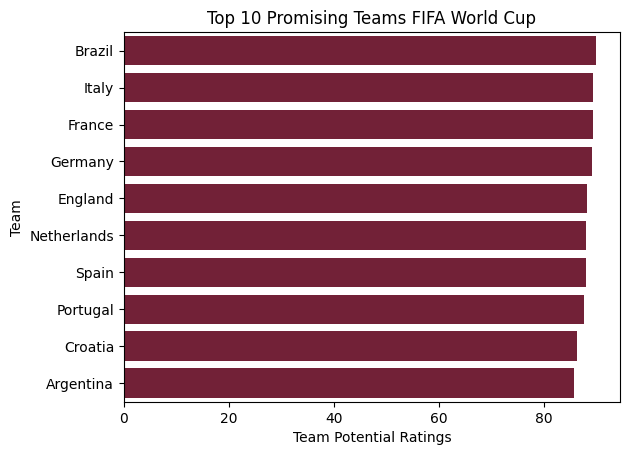

In [ ]:
x = country_top10['index']
y = country_top10['potential']

# plot
ax= sns.barplot(x=y, y=x, color="#7F1431", orient='h')
plt.xlabel('Team Potential Ratings', size = 10)
plt.ylabel('Team', size = 10 )
plt.title('Top 10 Promising Teams FIFA World Cup')

plt.show()